<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_8%5DAnalyzing_the_Sensibility_of_Film_Review_Texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_8]Analyzing the Sensibility of Film Review Texts

## 1. pip 설치 및 import




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### lolab GPU 이슈를 해결하기 위하여 다음과 같이 버전을 다운그레이드 해주었다.


In [2]:
# !pip install tensorflow==2.8
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

### konlpy등 필요한 모듈을 다운로드 받았고 다음의 링크에서 가져왔다.->https://sanghyu.tistory.com/170

In [3]:
# %%bash
# apt-get update
# apt-get install g++ openjdk-8-jdk python-dev python3-dev
# pip3 install JPype1
# pip3 install konlpy

In [4]:
# %env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

In [5]:
# %%bash
# bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
# pip3 install /tmp/mecab-python-0.996

In [6]:
import pandas as pd
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf


In [7]:
print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.6.0


## 2. 데이터 준비와 확인

In [8]:
base_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석"
train_data = pd.read_table(base_path+'/ratings_train.txt')
test_data = pd.read_table(base_path+'/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 3. 데이터로더 구성

- 데이터의 중복 제거

- NaN 결측치 제거

- 한국어 토크나이저로 토큰화

- 불용어(Stopwords) 제거

- 사전word_to_index 구성

- 텍스트 스트링을 사전 인덱스 스트링으로 변환

- X_train, y_train, X_test, y_test, word_to_index 리턴

In [9]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [10]:
index_to_word = {index:word for word, index in word_to_index.items()}

- key와 word의 위치를 바꿔줌

In [11]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [12]:
for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0
[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨:  1
[24, 205, 2]
재 <UNK>
라벨:  0
[8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정
라벨:  0
[2, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 2, 2, 427, 3102, 1766, 6]
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  1
[675, 2, 2, 131, 420, 185, 1547, 712, 65, 1694, 715, 53, 375, 192, 271, 5, 4, 69, 4, 11, 2179, 122, 750, 4]
<UNK> <UNK> 3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 . ㅋㅋㅋ . .. 별반 개 아까움 .
라벨:  0
[253, 381, 9, 384, 2012, 55, 15, 817, 6, 4]
긴장감 을 제대로 살려 내 지 못했 다 .
라벨:  0
[232, 1450, 144, 6, 425, 756, 2, 2, 52, 1532, 290, 99, 250, 4, 4, 28, 855, 29, 353, 652, 540, 509, 583, 6, 3318, 4, 8895, 22, 1460, 1460, 4, 4, 71, 304, 17, 6, 52, 104, 8, 77, 22, 2, 43]
반개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 . . 정말 발 로 해도 그

## 4. 모델 구성을 위한 데이터 분석 및 가공

데이터셋 내 문장 길이 분포

적절한 최대 문장 길이 지정

keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [13]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [14]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [15]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [16]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 5. 모델 구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### 1) LSTM




In [17]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          200000    
                                                                 
 lstm (LSTM)                 (None, 8)                 928       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 201,009
Trainable params: 201,009
Non-trainable params: 0
_________________________________________________________________


### 2) 1-D CNN

In [18]:
vocab_size = 10000  
word_vector_dim = 20   

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 20)          200000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          2256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

### 3) GlobalMaxPooling1D()

In [19]:
vocab_size = 10000 
word_vector_dim = 20  

model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 20)          200000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 20)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 168       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 200,177
Trainable params: 200,177
Non-trainable params: 0
_________________________________________________________________


In [20]:
# validation set 10000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


## 6. 모델 훈련 개시

### 1) LSTM

In [21]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 5s 10ms/step - loss: 0.5431 - accuracy: 0.7467 - val_loss: 0.3968 - val_accuracy: 0.8338
Epoch 2/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3556 - accuracy: 0.8518 - val_loss: 0.3568 - val_accuracy: 0.8468
Epoch 3/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3246 - accuracy: 0.8655 - val_loss: 0.3558 - val_accuracy: 0.8456
Epoch 4/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3103 - accuracy: 0.8733 - val_loss: 0.3533 - val_accuracy: 0.8478
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2996 - accuracy: 0.8786 - val_loss: 0.3575 - val_accuracy: 0.8462
Epoch 6/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2904 - accuracy: 0.8816 - val_loss: 0.3602 - val_accuracy: 0.8473
Epoch 7/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2826 - accuracy: 0.8857 - val_loss: 0.3636 - val_accuracy: 0.8454
Epoch

In [22]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4821 - accuracy: 0.8313 - 4s/epoch - 2ms/step
[0.4820825159549713, 0.8313363194465637]


### 2) 1-D CNN

In [23]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 7ms/step - loss: 0.5252 - accuracy: 0.7298 - val_loss: 0.3698 - val_accuracy: 0.8380
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3350 - accuracy: 0.8566 - val_loss: 0.3507 - val_accuracy: 0.8489
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2935 - accuracy: 0.8777 - val_loss: 0.3466 - val_accuracy: 0.8503
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2627 - accuracy: 0.8928 - val_loss: 0.3527 - val_accuracy: 0.8502
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2316 - accuracy: 0.9083 - val_loss: 0.3672 - val_accuracy: 0.8467
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.1974 - accuracy: 0.9252 - val_loss: 0.3978 - val_accuracy: 0.8412
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.1655 - accuracy: 0.9405 - val_loss: 0.4503 - val_accuracy: 0.8390
Epoch 

In [24]:
results = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0353 - accuracy: 0.8167 - 3s/epoch - 2ms/step
[1.0353118181228638, 0.8167096972465515]


### 3) GlobalMaxPooling1D()

In [25]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = model_gmp.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 1s 5ms/step - loss: 0.6086 - accuracy: 0.7741 - val_loss: 0.4676 - val_accuracy: 0.8209
Epoch 2/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3958 - accuracy: 0.8365 - val_loss: 0.3686 - val_accuracy: 0.8376
Epoch 3/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3325 - accuracy: 0.8606 - val_loss: 0.3536 - val_accuracy: 0.8432
Epoch 4/20
188/188 [==============================] - 1s 4ms/step - loss: 0.3003 - accuracy: 0.8756 - val_loss: 0.3512 - val_accuracy: 0.8473
Epoch 5/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2762 - accuracy: 0.8871 - val_loss: 0.3547 - val_accuracy: 0.8472
Epoch 6/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2563 - accuracy: 0.8967 - val_loss: 0.3620 - val_accuracy: 0.8465
Epoch 7/20
188/188 [==============================] - 1s 4ms/step - loss: 0.2394 - accuracy: 0.9049 - val_loss: 0.3707 - val_accuracy: 0.8444
Epoch 

In [26]:
results = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5789 - accuracy: 0.8224 - 2s/epoch - 2ms/step
[0.5788601040840149, 0.8223650455474854]


## 7. Loss, Accuracy 그래프 시각화

### 1) LSTM

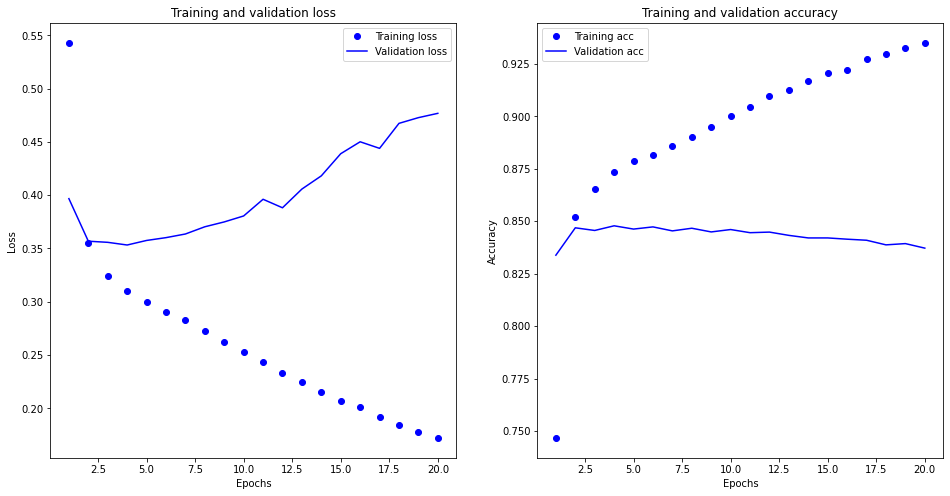

In [27]:
import matplotlib.pyplot as plt

history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

f, ax = plt.subplots(1,2,figsize=(16,8))

# "bo"는 "파란색 점"입니다
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()


### 2) 1-D CNN

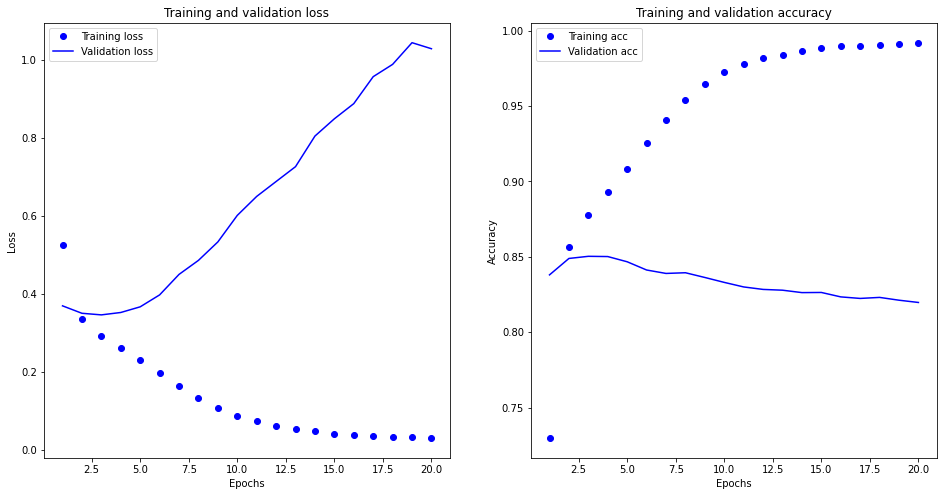

In [28]:
history_dict = history_cnn.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

f, ax = plt.subplots(1,2,figsize=(16,8))

# "bo"는 "파란색 점"입니다
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()


### GlobalMaxPooling1D()

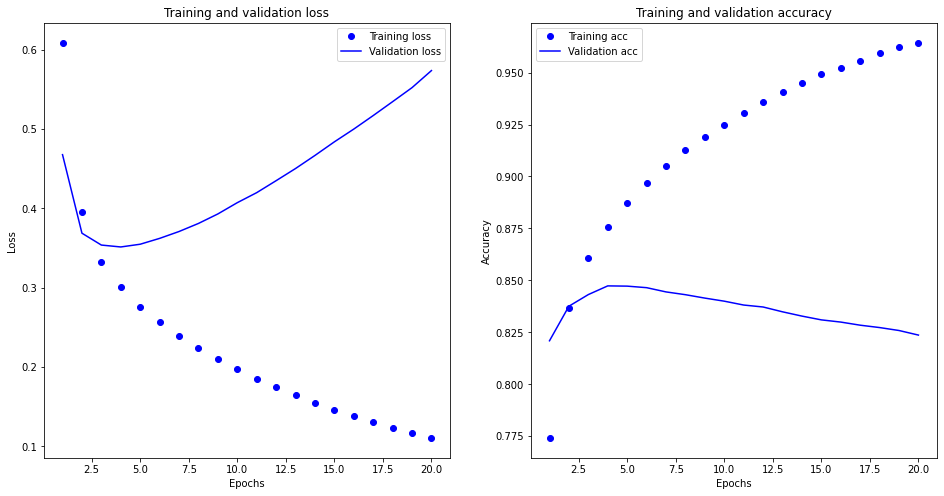

In [29]:
history_dict = history_gmp.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

f, ax = plt.subplots(1,2,figsize=(16,8))

# "bo"는 "파란색 점"입니다
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()


## 8. 학습된 Embedding 레이어 분석

In [30]:
! pip list | grep gensim

gensim                        3.6.0


### 1) LSTM

In [31]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [32]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_lstm = '/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석/data/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
vector = word_vectors['영화']
print(vector)

print(word_vectors.similar_by_word("스릴러"))

[ 0.0490797  -0.05264287 -0.0417667   0.04421541  0.03082426 -0.02823609
 -0.03472615 -0.0169612   0.11593214  0.01681015 -0.09800262 -0.05856816
  0.03036202  0.05319329  0.10460111 -0.00938441  0.13137335 -0.02548964
 -0.03569313  0.02099855]
[('사운드트랙', 0.7388288974761963), ('바티칸', 0.7110235095024109), ('롭', 0.7026118040084839), ('국', 0.7012497782707214), ('럽', 0.7004551887512207), ('였으면', 0.6921318769454956), ('세기', 0.6910960078239441), ('청불', 0.684482216835022), ('전투', 0.6837091445922852), ('81', 0.677270770072937)]


### 2) 1-D CNN

In [34]:
embedding_layer = model_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [35]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_cnn = '/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석/data/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)
vector = word_vectors['영화']
print(vector)

print(word_vectors.similar_by_word("로맨스"))

[ 0.07878017 -0.00507474  0.01554953  0.05285764 -0.01402899 -0.06055846
  0.03173439  0.0589839   0.0131046  -0.0493544  -0.02369308 -0.0563182
  0.03386443  0.00892005 -0.04771272 -0.00408991  0.01351654 -0.07229407
  0.0025152   0.12718585]
[('낮', 0.8632968664169312), ('장기', 0.844476580619812), ('최진실', 0.8133935928344727), ('알차', 0.81264328956604), ('클로이', 0.8102652430534363), ('강', 0.809208333492279), ('픈', 0.8089319467544556), ('돋보이', 0.8052185773849487), ('각인', 0.7941707968711853), ('의리', 0.7924220561981201)]


### 3) GlobalMaxPooling1D()

In [37]:
embedding_layer = model_gmp.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [38]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_gmp = '/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석/data/word2vec_gmp.txt'
f = open(word2vec_file_path_gmp, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_gmp.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [39]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_gmp, binary=False)
vector = word_vectors['영화']
print(vector)

print(word_vectors.similar_by_word("코미디"))

[ 0.20097525 -0.21668744 -0.22317801 -0.24070418 -0.1885865  -0.30017945
 -0.19323872 -0.19733696 -0.23610264 -0.26761508 -0.22568335 -0.19923986
 -0.22269283 -0.1771545  -0.2450453  -0.18495792 -0.2950087  -0.19434653
 -0.19775645 -0.19660683]
[('참', 0.9074161052703857), ('.........', 0.9005693197250366), ('난다', 0.8865447044372559), ('문화', 0.8844483494758606), ('2', 0.8713869452476501), ('턱', 0.8706406950950623), ('이것', 0.8598968982696533), ('음', 0.853265106678009), ('tv', 0.8507785797119141), ('너무', 0.8494600057601929)]


- 자체 학습한 임베딩은 그닥 성능이 좋지 않은 것을 확인할 수 있다.

## 9. 한국어 Word2Vec 임베딩 활용하여 성능 개선

### 1) Word2Vec 임베딩 적용

In [40]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = "/content/drive/MyDrive/error_model/word2vec_ko.model"
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv
vector

In [41]:
vector.similar_by_word("액션")

[('코미디', 0.7429822683334351),
 ('스릴러', 0.7381718754768372),
 ('판타지', 0.6900153160095215),
 ('호러', 0.6892675757408142),
 ('SF', 0.6889280676841736),
 ('롤플레잉', 0.6625269651412964),
 ('영화', 0.6522793769836426),
 ('서스펜스', 0.645000696182251),
 ('어드벤처', 0.6273845434188843),
 ('미스터리', 0.6250677108764648)]

In [42]:
vector.similar_by_word("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775139808654785),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844791412354),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113527655601501),
 ('로맨틱', 0.7107658386230469),
 ('장편', 0.7101576328277588),
 ('극영화', 0.7045413255691528)]

In [43]:
vocab_size = 10000
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
n = 0
for i in range(4,vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

### 2) 모델구현

In [44]:
from tensorflow.keras.initializers import Constant

### 1) LSTM

In [45]:

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size,
                                        word_vector_dim,
                                        input_length=maxlen,
                                        embeddings_initializer=Constant(embedding_matrix),
                                        trainable=True))
model_lstm.add(tf.keras.layers.LSTM(512)) 
model_lstm.add(tf.keras.layers.Dense(128, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(64, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 lstm_1 (LSTM)               (None, 512)               1255424   
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,329,409
Trainable params: 2,329,409
Non-trainable params: 0
_________________________________________________________________


### 2) 1-D CNN

In [46]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size,
                                        word_vector_dim,
                                        input_length=maxlen,
                                        embeddings_initializer=Constant(embedding_matrix),
                                        trainable=True))
model_cnn.add(tf.keras.layers.Conv1D(512, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(512, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())

model_cnn.add(tf.keras.layers.Dense(128, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(64, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 512)           358912    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 512)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 512)            1835520   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 128)              

### 3) GlobalMaxPooling1D

In [47]:
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size,
                                        word_vector_dim,
                                        input_length=maxlen,
                                        embeddings_initializer=Constant(embedding_matrix),
                                        trainable=True))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D()) 
model_gmp.add(tf.keras.layers.Dense(512, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(512, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.ㅏ
model_gmp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 global_max_pooling1d_3 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 512)               51712     
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 1)                 513       
                                                                 
Total params: 1,314,881
Trainable params: 1,314,881
Non-trainable params: 0
____________________________________________

In [48]:
print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


## 3) compile 및 모델학습

In [49]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
            
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 1) LSTM

In [50]:
epochs=35  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm2 = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/35
1503/1503 [==============================] - 23s 14ms/step - loss: 0.4118 - accuracy: 0.8086 - val_loss: 0.3508 - val_accuracy: 0.8451
Epoch 2/35
1503/1503 [==============================] - 19s 12ms/step - loss: 0.2991 - accuracy: 0.8724 - val_loss: 0.3086 - val_accuracy: 0.8673
Epoch 3/35
1503/1503 [==============================] - 19s 12ms/step - loss: 0.2474 - accuracy: 0.8967 - val_loss: 0.3185 - val_accuracy: 0.8674
Epoch 4/35
1503/1503 [==============================] - 20s 14ms/step - loss: 0.1932 - accuracy: 0.9221 - val_loss: 0.3471 - val_accuracy: 0.8668
Epoch 5/35
1503/1503 [==============================] - 19s 13ms/step - loss: 0.1369 - accuracy: 0.9465 - val_loss: 0.4040 - val_accuracy: 0.8635
Epoch 6/35
1503/1503 [==============================] - 19s 13ms/step - loss: 0.0956 - accuracy: 0.9631 - val_loss: 0.4975 - val_accuracy: 0.8587
Epoch 7/35
1503/1503 [==============================] - 19s 13ms/step - loss: 0.0728 - accuracy: 0.9721 - val_loss: 0.5629 -

In [51]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.9171 - accuracy: 0.8510 - 5s/epoch - 3ms/step
[0.9170721769332886, 0.851028323173523]


### 2) 1-D CNN

In [52]:
epochs=35  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/35
1503/1503 [==============================] - 15s 9ms/step - loss: 0.4664 - accuracy: 0.7755 - val_loss: 0.3848 - val_accuracy: 0.8286
Epoch 2/35
1503/1503 [==============================] - 13s 8ms/step - loss: 0.3425 - accuracy: 0.8504 - val_loss: 0.3565 - val_accuracy: 0.8440
Epoch 3/35
1503/1503 [==============================] - 13s 8ms/step - loss: 0.2830 - accuracy: 0.8794 - val_loss: 0.3694 - val_accuracy: 0.8399
Epoch 4/35
1503/1503 [==============================] - 13s 8ms/step - loss: 0.2297 - accuracy: 0.9048 - val_loss: 0.3770 - val_accuracy: 0.8476
Epoch 5/35
1503/1503 [==============================] - 13s 8ms/step - loss: 0.1777 - accuracy: 0.9284 - val_loss: 0.4301 - val_accuracy: 0.8413
Epoch 6/35
1503/1503 [==============================] - 13s 8ms/step - loss: 0.1364 - accuracy: 0.9460 - val_loss: 0.5286 - val_accuracy: 0.8395
Epoch 7/35
1503/1503 [==============================] - 13s 9ms/step - loss: 0.1062 - accuracy: 0.9583 - val_loss: 0.6114 - val_ac

In [53]:
results = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 1.5002 - accuracy: 0.8380 - 4s/epoch - 2ms/step
[1.5002248287200928, 0.8380495309829712]


### 3) GlobalMaxPooling1D

In [54]:
epochs=35  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_gmp.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/35
1503/1503 [==============================] - 7s 5ms/step - loss: 0.6008 - accuracy: 0.6760 - val_loss: 0.5402 - val_accuracy: 0.7250
Epoch 2/35
1503/1503 [==============================] - 7s 4ms/step - loss: 0.5233 - accuracy: 0.7366 - val_loss: 0.4968 - val_accuracy: 0.7560
Epoch 3/35
1503/1503 [==============================] - 7s 4ms/step - loss: 0.4827 - accuracy: 0.7660 - val_loss: 0.4746 - val_accuracy: 0.7721
Epoch 4/35
1503/1503 [==============================] - 7s 4ms/step - loss: 0.4523 - accuracy: 0.7852 - val_loss: 0.4612 - val_accuracy: 0.7761
Epoch 5/35
1503/1503 [==============================] - 7s 4ms/step - loss: 0.4303 - accuracy: 0.7995 - val_loss: 0.4733 - val_accuracy: 0.7684
Epoch 6/35
1503/1503 [==============================] - 7s 4ms/step - loss: 0.4117 - accuracy: 0.8114 - val_loss: 0.4324 - val_accuracy: 0.7993
Epoch 7/35
1503/1503 [==============================] - 7s 5ms/step - loss: 0.3957 - accuracy: 0.8197 - val_loss: 0.4310 - val_accuracy:

In [55]:
results = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8082 - accuracy: 0.8080 - 3s/epoch - 2ms/step
[0.8081644773483276, 0.8079825639724731]


## 10. 85% 이상 모델 선정

### 1) RNN의 레이어인 LSTM이 85% 이상을 달성하였다.
  - 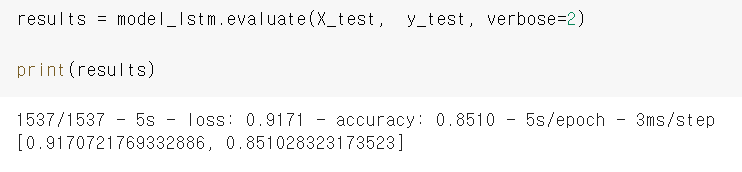

### 2) 당첨기념으로 LOSS Accuracy 그래프 살펴보기

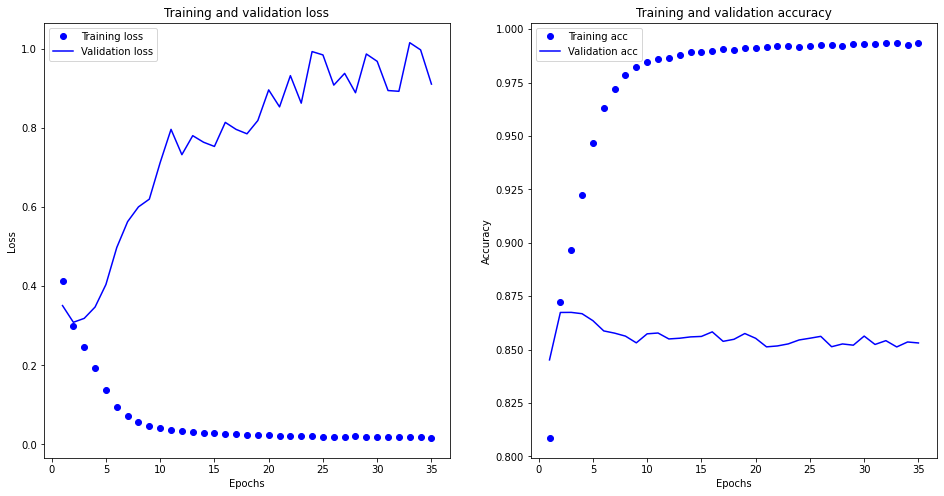

In [56]:
history_dict = history_lstm2.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

f, ax = plt.subplots(1,2,figsize=(16,8))

# "bo"는 "파란색 점"입니다
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()


### 3) 한국어 Word2Vec를 통한 사전학습모델로 임베딩한 결과 분석

In [57]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_lstm = '/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석/data/word2vec_lstm2.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [61]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
vector = word_vectors['영화']
vector

array([-1.3408376e+00, -7.8175658e-01, -1.6177264e+00,  1.4927088e+00,
       -3.4475550e-01,  6.5283120e-01, -4.4165335e+00, -3.1590564e+00,
        5.1767290e-01,  1.2286451e+00, -2.8508444e+00, -1.2989303e+00,
       -2.0647585e+00, -3.8337622e+00,  2.0447667e+00, -2.1389122e+00,
       -7.6411419e-02, -1.2552574e+00,  2.6638920e+00, -9.3945283e-01,
       -8.3058769e-01,  2.0310652e+00,  7.6758039e-01,  1.6984028e+00,
        2.3303638e+00, -1.6585586e+00, -1.7379018e+00,  1.1559515e+00,
        5.9276927e-01, -1.1460145e+00, -3.7017684e+00,  3.9122331e+00,
        5.6283629e-01, -7.4263829e-01,  1.2938123e+00,  3.1465585e+00,
        1.6473525e+00, -6.6753888e-01,  5.5994734e-02,  5.8041632e-01,
        1.3017753e+00, -2.6752422e+00,  1.2233806e+00,  1.0027102e+00,
        3.0594194e+00,  3.1040597e+00,  2.3289652e+00,  8.3023137e-01,
        1.9685595e+00, -4.7444062e+00,  4.6644801e-01, -2.3644102e+00,
        4.8393831e+00, -2.9096565e+00, -5.1010174e-01, -1.9632924e+00,
      

In [62]:
word_vectors.similar_by_word("액션")

[('스릴러', 0.7169010639190674),
 ('코미디', 0.7048879861831665),
 ('SF', 0.6684247851371765),
 ('판타지', 0.6658772230148315),
 ('서부극', 0.6442108750343323),
 ('호러', 0.6318056583404541),
 ('느와르', 0.6077871322631836),
 ('어드벤처', 0.6026875972747803),
 ('모션', 0.6003382205963135),
 ('영화', 0.5956229567527771)]

In [63]:
word_vectors.similar_by_word("영화")

[('드라마', 0.7904802560806274),
 ('뮤지컬', 0.7440629005432129),
 ('헐리우드', 0.717823326587677),
 ('다큐멘터리', 0.7016750574111938),
 ('장편', 0.6991208791732788),
 ('코미디', 0.6787695288658142),
 ('로맨틱', 0.6733047366142273),
 ('애니메이션', 0.6638368368148804),
 ('SF', 0.6598117351531982),
 ('서부극', 0.6595515012741089)]

- Word2Vec 사전 학습 임베딩과 이를 통한 학습결과 비교(미묘한 차이는 있으나 판단하기 어렵다.)
  - 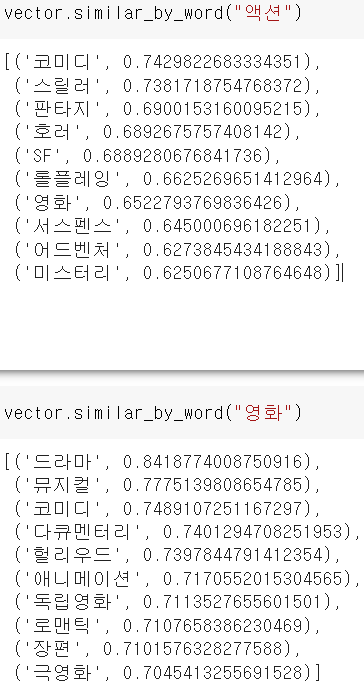
- 사전학습 모델을 통한 재임베딩 결과와 자체학습 임베딩 비교(차이가 매우 큰 것을 확인 할 수 있다.)
  - 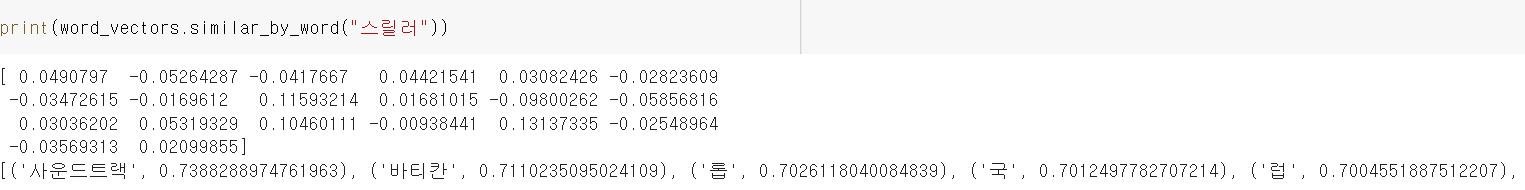

# 회고
- 루브릭 조건을 맞추기 위해서 시도한것
  - batch_size가 크면 학습이 빨리 되기는 하나 데이터가 적어 정확도가 떨어지는 경향이 있다. 그래서 batch_size를 줄였다.
  - epoch또한 35로 늘려주어 정확도를 올릴 수 있었다.
  - 차원수를 512까지 Dense를 보다 심층화 시켜 정확도를 올릴 수 있었다.

- 어려웠던 점
  - 자체학습한 임베딩과 사전학습 임베딩을 분석하라는데 사실 무슨 말인지 이해가 안되었다. 그러나 LMS를 다시 살펴보니 잘 설명이 되어있었다. LMS를 좀 더 꼼꼼히 읽을 필요가 있는 것 같다.
    - 결론적으로 자체학습 임베딩이란 위의 학습한 다음 자체적으로 임베딩 레이어를 만든 것
    - 사전학습 임베딩 레이어는 한국어 Word2Vec이라는 사전학습된 워드 임베딩 모델을 가져와 사용함으로써 정확도를 보다 높여주었다.
      - 여기에서 정확도란 단순히 학습결과값 수치만을 뜻하는 것은 아니다. 수치는 좋지만 실제 정성적 결과는 좋지 않은 경우가 많다. 
      - 분명 사전학습이 정량적 수치인 정확도를 올리기 더 어려웠다. 하지만 정성적인 결과는 더 좋았다. 이는 사전학습모델을 바탕으로 다시 임베딩 레이어를 생성하여 확인할 수 있었다.

- 추가로 공부하게 된 것
  - 임베딩 레이어 결과를 출력할 때 자체학습과 사전학습을 다르게 해야한다는 것을 알게 되었다.
  - 자체학습은 이미 학습이 끝났기 때문에 vector에 '영화'등과 같은 특정 문자를 넣어서 결과를 확인해도 되었다.
  - 하지만 사전임베딩을 적용할때는 vector 객체를 만들때 '영화'등과 같은 문자를 넣으면 성능이 떨어지는 것을 확인할 수 있다. 당연히 이것을 바탕으로 학습을 해야하는데 '영화'라는 값으로 한정했기 때문으로 추측하고 있다.
    - 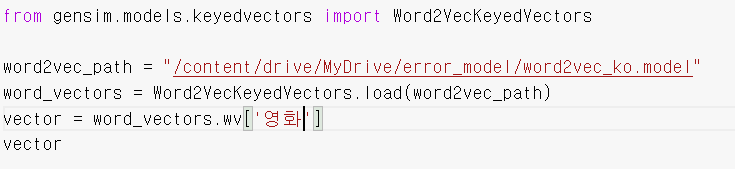
  - 그래서 사전학습은 vector객체에 불순 문자를 넣지 않고 그냥 similar_by_word로 단어별로 확인만 해주었다.